In [124]:
# Load the "autoreload" extension
%load_ext autoreload

%autoreload 2

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'faster_rcnn')
sys.path.append(src_dir)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import cv2
from shapes import Image
from data import voc_data_helpers
from data.voc_data_helpers import extract_img_data
from det_util import DetTrainingManager
from shared_constants import RESIZE_MIN_SIZE, RESIZE_MAX_SIZE
from util import transform
%matplotlib inline




import keras
from keras import backend as K
from keras.layers import Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.models import Model, model_from_json
from keras.optimizers import SGD
import resnet
from resnet import resnet50_rpn, resnet50_classifier, resnet50_base, preprocess, pop_layer, resnet101_base, resnet50_rpn, resnet101_base, resnet101_rpn, resnet101_classifier
import vgg
from vgg import vgg16_rpn, vgg16_classifier, vgg16_base
from custom_layers import RoiResizeConv
from data import voc_data_helpers
from loss_functions import cls_loss_rpn, bbreg_loss_rpn, cls_loss_det, bbreg_loss_det

VOC_PATH = '/Users/ke/Downloads/VOCdevkit/VOC2007'

NUM_ROIS = 64

print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [126]:
rpn = resnet.rpn_from_h5('../models/rpn_model_r101_fullreg_step3_kitti_train.h5')

/Users/ke/miniconda3/envs/capstone/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [127]:
detector = resnet.det_from_h5('../models/detector_model_r101_fullreg_step4_kitti_train.h5', 10)

In [210]:
voc_path = '/Users/ke/mlnd/tmp/kitti/voc_format/VOC2012/'
class_mapping = voc_data_helpers.KITTI_CLASS_MAPPING
image = voc_data_helpers.extract_img_data(voc_path, '006600')
image, resized_ratio = image.resize_within_bounds(600, 1500)
batched_img = np.expand_dims(image.data, axis=0)
preprocessed = preprocess(image.data)
batched_preprocessed = np.expand_dims(preprocessed, axis=0)

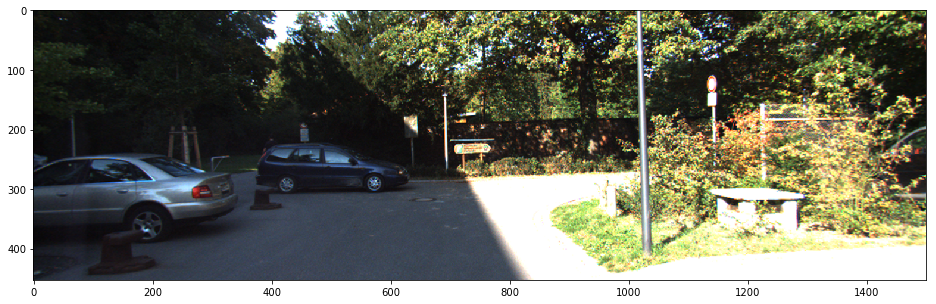

In [211]:
rgb_data = cv2.cvtColor(image.data, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
plt.imshow(rgb_data)

In [212]:
manager = DetTrainingManager(rpn_model=rpn, class_mapping=class_mapping, preprocess_func=preprocess)

In [213]:
rpn_input, rois_r50, y_class_num, y_transform = manager.get_training_input(image)

Executed function get_training_input in 5.19538308121264 seconds
    Executed function _get_det_samples in 0.0001403982751071453 seconds
    Executed function _process in 5.194860110990703 seconds
        Executed function _rois_to_truth in 0.004682725761085749 seconds
            Executed function _one_hot_encode_bbreg in 0.0009977202862501144 seconds
            Executed function _one_hot_encode_cls in 0.0001199464313685894 seconds
            Executed function cross_ious in 0.00034547364339232445 seconds
        Executed function nms in 0.23570385109633207 seconds
        Executed function _get_valid_box_idxs in 0.0005908878520131111 seconds
        Executed function _rois_from_image in 4.941499695181847 seconds
            Executed function _get_rois in 0.013176016975194216 seconds
                Executed function _get_rois in 0.013168823905289173 seconds
                    Executed function _sanitize_boxes_inplace in 0.007145304698497057 seconds
                    Executed func

In [214]:
cls_out, reg_out = detector.predict_on_batch([rpn_input, rois_r50])

In [215]:
print(rois_r50)
print(np.argmax(cls_out[0,0:64], axis=1))
idx = 0
cls_num = 0
print(rois_r50[0,idx])
print(rois_r50[0,idx] * 16)
bbreg = reg_out[0,idx,4*cls_num:4*(cls_num+1)] / np.array([10, 10, 5, 5])
print(bbreg)
print(transform(rois_r50[0,idx] * 16, bbreg))
new_coords = [transform(rois_r50[0,idx], bbreg)]

[[[ 0 15 15 26]
  [87 12 92 23]
  [ 0 13 16 24]
  [ 0 12 20 23]
  [ 6 14 28 25]
  [24 13 26 18]
  [88 11 93 22]
  [ 3 15 25 26]
  [ 0 14 21 25]
  [22 14 33 19]
  [ 4 13 20 28]
  [ 0 12 24 28]
  [28 14 39 19]
  [25 14 36 19]
  [ 0 16 19 27]
  [ 2 13 24 24]
  [ 7 12 12 23]
  [21 13 25 17]
  [29  4 40 26]
  [ 0 23 18 28]
  [26  7 42 23]
  [13 15 24 20]
  [34  9 39 20]
  [26 10 31 21]
  [27 16 38 21]
  [ 4  7 20 23]
  [30 15 34 19]
  [24  8 56 28]
  [24  5 40 21]
  [17  6 28 28]
  [31 14 33 19]
  [30 14 35 25]
  [27 12 59 28]
  [ 2 12 34 28]
  [80 16 91 21]
  [20  0 42 24]
  [ 0 12 10 28]
  [ 0  9 12 25]
  [ 0  0 11 24]
  [23  9 31 17]
  [36 13 47 18]
  [32 12 43 17]
  [ 0 16 10 21]
  [ 3 10 19 26]
  [11  6 22 28]
  [ 6 21 17 26]
  [ 0  2  8 24]
  [85  0 93 15]
  [35 10 40 21]
  [ 6 17 28 28]
  [28  0 39 19]
  [24 12 25 14]
  [26 14 31 16]
  [30 13 34 17]
  [15 14 23 22]
  [23 14 25 16]
  [ 1 14  6 25]
  [22 13 30 21]
  [ 0 17 11 22]
  [21 12 25 16]
  [88 17 93 22]
  [29  9 37 17]
  [91  6

[(-0.14404045566083212, 14.454609107354077, 22.430173268160832, 24.923512292525377)]


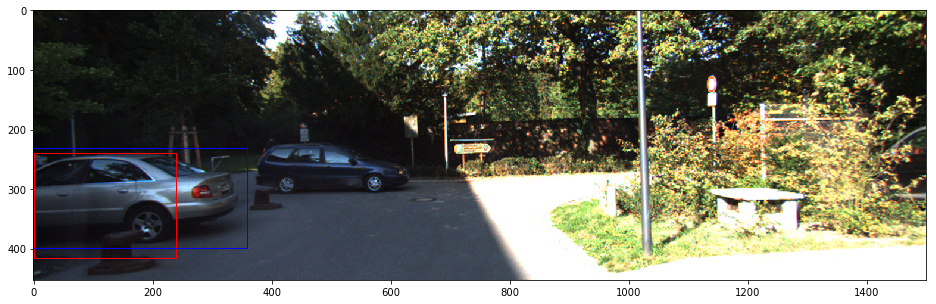

In [216]:
import matplotlib.gridspec as gridspec

fig,ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(rgb_data)

for x1,y1,x2,y2 in rois_r50[0,idx:idx+1]:
# for x1,y1,w,h in rois_r50[0,0:32]:
    x = x1 * 16
    y = y1 * 16
    w = (x2 - x1) * 16
    h = (y2 - y1) * 16
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
print(new_coords)
for x1,y1,x2,y2 in new_coords:
    x = x1 * 16
    y = y1 * 16
    w = (x2 - x1) * 16
    h = (y2 - y1) * 16
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

In [217]:
(np.array(new_coords)*16)/resized_ratio

array([[  -1.90824796,  191.49466145,  297.15493546,  330.18669085]])

[<shapes.GroundTruthBox obj_cls: car, difficult: False, box: <image.Box x1: 0.0, y1: 236.71497584541063, x2: 356.280193236715, y2: 394.92753623188406>>, <shapes.GroundTruthBox obj_cls: person, difficult: False, box: <image.Box x1: 385.2657004830918, y1: 205.31400966183577, x2: 408.21256038647346, y2: 282.60869565217394>>, <shapes.GroundTruthBox obj_cls: car, difficult: False, box: <image.Box x1: 1390.096618357488, y1: 182.3671497584541, x2: 1498.792270531401, y2: 339.3719806763285>>, <shapes.GroundTruthBox obj_cls: car, difficult: False, box: <image.Box x1: 371.98067632850245, y1: 221.0144927536232, x2: 632.8502415458937, y2: 305.55555555555554>>]


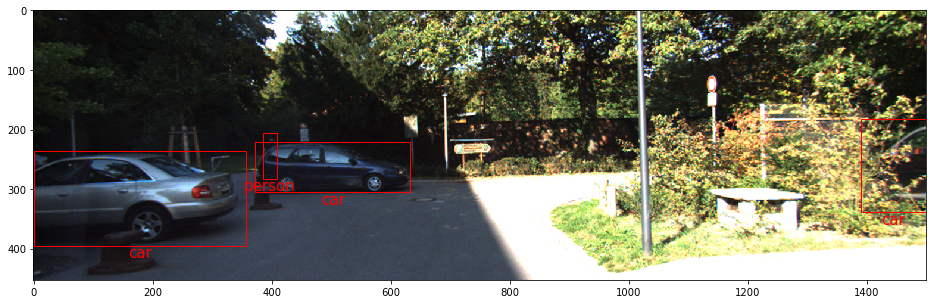

In [218]:
print(image.gt_boxes)
fig,ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(rgb_data)

for gt_box in image.gt_boxes:
    x, y, w, h = gt_box.corner_dims
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    label = gt_box.obj_cls 
    ax.text(x+w/2, y+h, label, ha="center", va="top", rotation=0,
            size=15,
            color='red',
            bbox=None)

In [219]:
resized_ratio

1.2077294685990339

In [220]:
from voc_dets import get_dets, get_dets_by_cls
dets = get_dets(manager, detector, image, resized_ratio, det_threshold=0.0)
# dets2 = get_dets_by_cls(manager, detector, [resized_ratio], [image], stride=16, det_threshold=0.0)

Executed function get_det_inputs in 4.434301936998963 seconds
    Executed function nms in 0.036219039000570774 seconds
    Executed function _get_valid_box_idxs in 0.00041612889617681503 seconds
    Executed function _rois_from_image in 4.385700401850045 seconds
        Executed function _get_rois in 0.01670939614996314 seconds
            Executed function _get_rois in 0.016702183987945318 seconds
                Executed function _sanitize_boxes_inplace in 0.0014763157814741135 seconds
                Executed function transform_np_inplace in 0.007078072056174278 seconds
                Executed function _get_anchor_coords in 0.0016757072880864143 seconds
        Executed function _out_from_image in 4.3397176447324455 seconds
        Executed function batched_image in 0.024020076263695955 seconds
num rois: 300
Executed function nms in 0.00010064523667097092 seconds
Executed function nms in 6.852718070149422e-05 seconds


In [221]:
dets

[{'bbox': array([ -2, 191, 299, 327]), 'cls_name': 'car', 'prob': 0.99999261},
 {'bbox': array([309, 181, 522, 254]), 'cls_name': 'car', 'prob': 0.99993181},
 {'bbox': array([320, 177, 335, 208]),
  'cls_name': 'Cyclist',
  'prob': 0.54340434}]

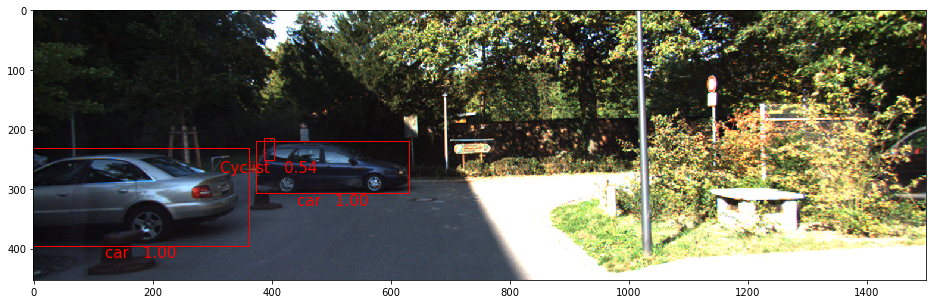

In [222]:
fig,ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(rgb_data)

for det in dets:
    x, y, w, h = np.array([det['bbox'][0], det['bbox'][1], det['bbox'][2] - det['bbox'][0], det['bbox'][3] - det['bbox'][1]])*resized_ratio
    rect = patches.Rectangle((x, y), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    label = "{} {:6.2f}".format(det['cls_name'], det['prob'])
    ax.text(x+w/2, y+h, label, ha="center", va="top", rotation=0,
            size=15,
            color='red',
            bbox=None)

In [223]:
detector.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
roi_input (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
roi_resize_conv_5 (RoiResizeCon (None, 64, 7, 7, 102 0           input_2[0][0]                    
                                                                 roi_input[0][0]                  
__________________________________________________________________________________________________
res5a_branch2a (TimeDistributed (None, 64, 7, 7, 512 524288      roi_resize_conv_5[0][0]          
__________